
# <span style="color:rgb(213,80,0)">Basic Diffusion Tensor Imaging with DMRIMatlab</span>

In the previous chapter we reviewed the basics of each type of diffusion\-related volume, but how can we get one kind of signal representation from the raw diffusion data? In this chapter we will start with the simplest one, i.e. the diffusion tensor representation. Hence, we will take an "attenuation volume", whose 4\-th dimension stacks all the channels acquired for different gradient directions and b\-values, and end\-up with a "tensor volume", whose 4\-th dimension has the 6 different components of the diffusion tensor.


 ***TO DO:*** Clear all variables and figures to start from zero (*Ctrl+ENTER*):


In [ ]:
addpath('..');
setup__DMRIMatlab_toolbox;
clear;
close('all');

## 1. Prepare the data

***BEFORE WE PROCEED***:

-  Note we need, at the very least, the attenuation signal and the minimal information to intepret it (i.e. the gradients table and b\-values). Let's load a test volume (*Ctrl+ENTER*):

In [ ]:
whos -file test_data.mat
% The minimum required information is: the attenuation signal atti, the
% gradients table gi and the b-values bi. Note their sizes mast match.
% Additionally, an optional mask whose field of view matches that of atti
% is useful to avoid unnecessary computations. Load them all:
load test_data.mat


-  The tensor model is a very simple one, and can explain only certain macroscopic effects of diffusion. In practice, this means that DTI is not usable for b\-values over $2,000s/mm^2$ . Don't forget this important issue if you work with multi\-shell data. Let's fix it:

In [ ]:
unique(bi)',
% There are values not suitable for DTI
bcut = 2000; % This should be the maximum value used for DTI
usable = (bi<=bcut);
atti = atti(:,:,:,usable);
gi = gi(usable,:);
bi = bi(usable,1);
size(gi),
size(bi),
size(atti),
% The dimensions still match...

## 2. Estimate the diffusion tensor

Now we are ready to estimate the diffusion tensor with the proper function. The expected input is an attenuation volume, and the expected output is a DTI volume. Hence, the function is named <samp>atti2dti</samp> (*Ctrl+ENTER*):


In [ ]:
% atti, gi and bi are the minimum required information, and therefore they
% are mandatory inputs that are passed as "positional arguments". All other
% input arguments are optional and are passed as 'key', value pairs:
tic;
dti = atti2dti( atti, gi, bi, ...
    'mask', mask, ...
    'wls', false, ...
    'nonlinear', false );
fprintf(1,'It took %1.3f seconds to estimate the diffusion tensor\n',toc);


***QUIZ:***


 *What is the meaning of the* *<samp>'wls'</samp>* *and* *<samp>'nonlinear'</samp>* *optional arguments? Try to change their values (* *<samp>false/true</samp>**) and check the effects on the computation times. Also, try to avoid using the mask (just remove the key/value pair from the input arguments) and check the computation times.*

<pre>
help atti2dti
</pre>

## 3. Estimate the spectrum of the diffusion tensor

The DTI volume we have just estimated stacks the 6 free components of the diffusion tensor in its 4\-th component (*Ctrl+ENTER*):


In [ ]:
size(dti),


However, these 6 number are difficult to interpret even if they are re\-arranged into the $3\times 3$ matrix that representes the diffusion tensor. To properly infer the actual diffusion properties of each voxel, we need to compute:

-  The 3 eigenvectors of the diffusion tensor, which provide the 3 main spatial directions along which diffusion occurs.
-  The 3 eigenvalues of the diffusion tensor, which provide the amount of diffusion (in $mm^2 /s$ ) along each of these directions.

<p style="text-align:left">
   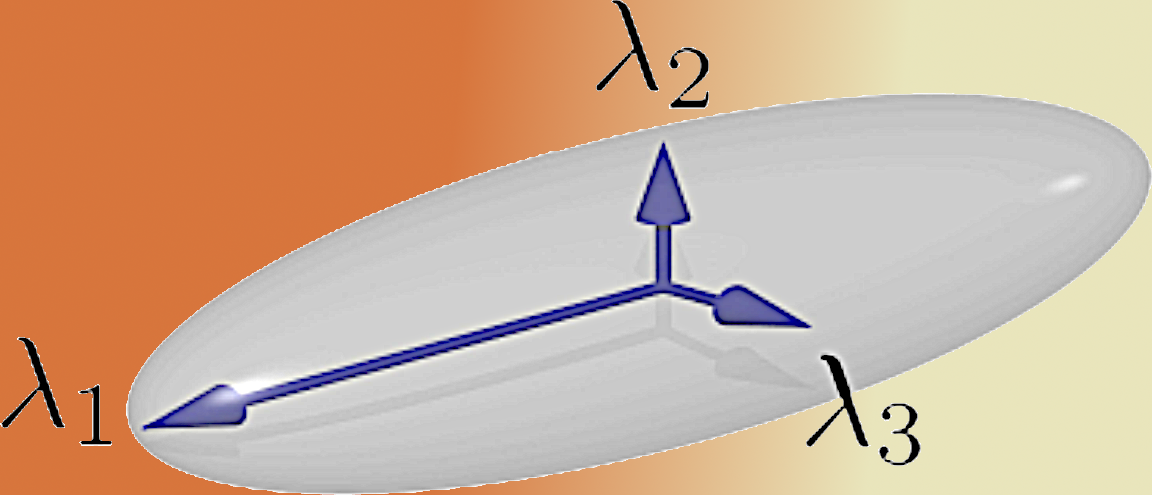
</p>


The three eigenvalues and the three eigenvectors make up the "spectrum" of the diffusion tensor. To compute it, we will use a function whose expected input is a DTI volume and whose expected output is the spectrum of the diffusion tensor. Hence, the name of the function is <samp>dti2spectrum</samp>:


In [ ]:
% The one and only required input is the DTI volume itself, which is the
% first positional argument. All other arguments are optional and are
% passed as 'key', value pairs:
[u1,u2,u3,l1,l2,l3] = dti2spectrum( dti, ...
    'mask', mask );


<samp>u1</samp>, <samp>u2</samp> and m are the eigenvectors (unit\-norm vectors with 3 components that are stored in the 4\-th dimension of each of the arrays), meanwhile <samp>l1</samp>, <samp>l2</samp> and <samp>l3</samp> are the (scalar) eigenvalues:


In [ ]:
size(u1), size(u2), size(u3),
size(l1), size(l2), size(l3),


We can have an idea of the values of <samp>l1</samp>, <samp>l2</samp> and <samp>l3</samp> by computing their histograms over the masked region:


In [ ]:
close(figure(1));
hf1 = figure(1);
colors = eye(3)/2;
hold('on');
hk = zeros(1,3);
for k=1:3
    lk = eval(sprintf('l%d',k));
    hk(k) = histogram( lk(mask), ...
        'EdgeAlpha', 0.5, 'FaceColor', ...
        colors(k,:), 'FaceAlpha', 0.4 );
end
axs = axis;
axis([-0.001,0.004,axs(3),axs(4)]);
legend(hk,'\lambda_1','\lambda_2','\lambda_3','Location','NorthEast');
xlabel('Amount of diffusion [mm^2/s]');
ylabel('Counts');


Some things to note:

-  The convention is ordering the eigenvalues in descending order, so that $\lambda_1$ is the largest one and therefore $u_1$ is the principal diffusion direction.
-  Theoretically, the amount of diffusion should range from 0 to $3.0\cdot 10^{-3} mm^2 /s$ , which is the diffusivity of free water at body temperature. However, due to noise and degeneracies the estimation procedure can yield out\-of\-range values.

***QUIZ:***


 *Go back to section 2, play around with different combinations of the optional arguments* *<samp>'wls'</samp>* *and* *<samp>'nonlinear'</samp>* *and run again this section afterwards to check the effect of these combinations on the diffusivities computed.*

## **4. Represent diffusion tensor\-based quantitative information**

Of course, we can represent the raw eigenvalues in an anatomical map to check their coherence. For example, for the largest one (*Ctrl+ENTER*):


In [ ]:
close(figure(2));
hf2 = figure(2);
set(hf2,'Position',[1,1,1200,400]);
plotSlicedVolume_demo1( hf2, l3, mask, [3,5,8,10,13,15] ); % This function is coded below
title('Main eigenvector');
drawnow;


As you can see, the maps ar anatomically coherent, and the maximum amount of diffusivity corresponds, obviously, to the cerebrospinal fluid inside the ventricles.


What about the other eigenvalues? We could, of course, repeat the plot for them. Or we could rather observe their joint behavior by representing their mean and their variability. Well, this "mean" and (normalized) "variability" of the three eigenvalues are what we call, respectively, the "Mean Diffusivity" and the "Fractional Anisotropy" of the diffusion tensor at each voxel. These two scalar measures are computed from the spectrum of the diffusion tensor, hence we will use a function named <samp>spectrum2scalar</samp>:


In [ ]:
% We need the three eigenvalues (note we do not need the eigenvectors) to
% compute them:
MD = spectrum2scalar(l1,l2,l3,'mask',mask,'scalar','md');
FA = spectrum2scalar(l1,l2,l3,'mask',mask,'scalar','fa');
close(figure(3));
hf3 = figure(3);
set(hf3,'Position',[1,1,1200,400]);
plotSlicedVolume_demo1( hf3, MD, mask, [3,5,8,10,13,15] );
title('Mean Diffusivity');
close(figure(4));
hf4 = figure(4);
set(hf4,'Position',[1,1,1200,400]);
plotSlicedVolume_demo1( hf4, FA, mask, [3,5,8,10,13,15] );
title('Fractional Anisotropy');


These two scalar measures are the ones most used in practice. Note that the MD has the same scale as the eigenvalues themselves, ranging from 0 to the free\-water diffusivity at body temperature ( $3.0\cdot 10^{-3} mm^2 /s$ ). The FA, on the contrary, is a normalized variance, ranging from 0 to 1 (though outliers greater than 1 might appear if negative eigenvalues are present):


In [ ]:
close(figure(5));
hf5 = figure(5);
histogram( FA(mask), 'EdgeAlpha', 0.5, ...
    'FaceColor', [.0,.0,.5], 'FaceAlpha', 0.4);
xlabel('Fractional Anisotropy values');
ylabel('Counts');


***QUIZ:***


 *Go back to section 2, play around with different combinations of the optional arguments* *<samp>'wls'</samp>* *and* *<samp>'nonlinear'</samp>* *and run again sections 3 and 4 afterwards to check the effect of these combinations on the FA computed.*


Note that the FA is large inside the white matter and small in the gray matter. Indeed, the value of the FA is usually thresholded to segment the white matter.


***QUIZ:***


 *What other scalar measurements can be computed from the eigenvalues of the diffusion tensor and what are their meanings? Can you represent some of them?*  ***HINT:***  *Check the function* *<samp>spectrum2scalar</samp>**.*

<pre>
help spectrum2scalar
</pre>

## 5. Represent directional information

Up to this point we have used only the eigenvalues (amount of diffusion along each axis) of the diffusion tensor, but we have completely neglected the direction information, i.e. the eigenvectors of the tensor. Is there an easy way to represent directional information? The answer is yes, through color\-coding.


Color\-coded maps embed the three components of the main eigenvector (<samp>u1</samp>, according to our convention) in the three channels of an RGB image, so that **red** prevails for voxels with meso\-structures aligned with the <samp>'x'</samp> axis, **green** prevails for voxels with meso\-structures aligned with the <samp>'y'</samp> axis and **blue** prevails for voxels with meso\-structures aligned with the <samp>'z'</samp> axis. <u>Remember that diffusion sequences cannot tell the positive orientation of one axis (e.g. </u><samp><u>'x'</u></samp><u>) from the negative one</u>. Besides, the brightness of each voxel is weighted by its FA to improve visualization and remove low\-anisotropy noise\-like voxels.


The color\-coded image is obtained from the spectrum of the diffusion tensor, hence the function to use is called  <samp>spectrum2colorcode</samp> (*Ctrl+ENTER*):


In [ ]:
% We need the main eigenvector to extract the RGB channels, and also the
% three eigenvalues to compute the FA and weight the brightness of each
% voxel:
colored = spectrum2colorcode(u1,l1,l2,l3,'mask',mask);
% The first three dimensions are the field of view, and the 4-th one, with
% size 3, contains the 3 channels R, G and B:
size(colored),
% Plot the results:
close(figure(6));
hf6 = figure(6);
set(hf6,'Position',[1,1,1200,400]);
plotSlicedVolume_demo1( hf6, colored, mask, [3,5,8,10,13,15] );
title('Color-coding');


***QUIZ:***


*Can you identify the big bright, magenta structure right in the middle of the fifth slice? And the four bright green spots that surround it? Why do they have these colors?*

## 6. Some other representations?

If you are familiar with Diffusion Tensor Imaging, or you have ever felt curious about it, it is likely that you have found fancy pictures with plots of nerve fibers or the diffusion ellipsoids themselves placed at each voxel:

<p style="text-align:left">
   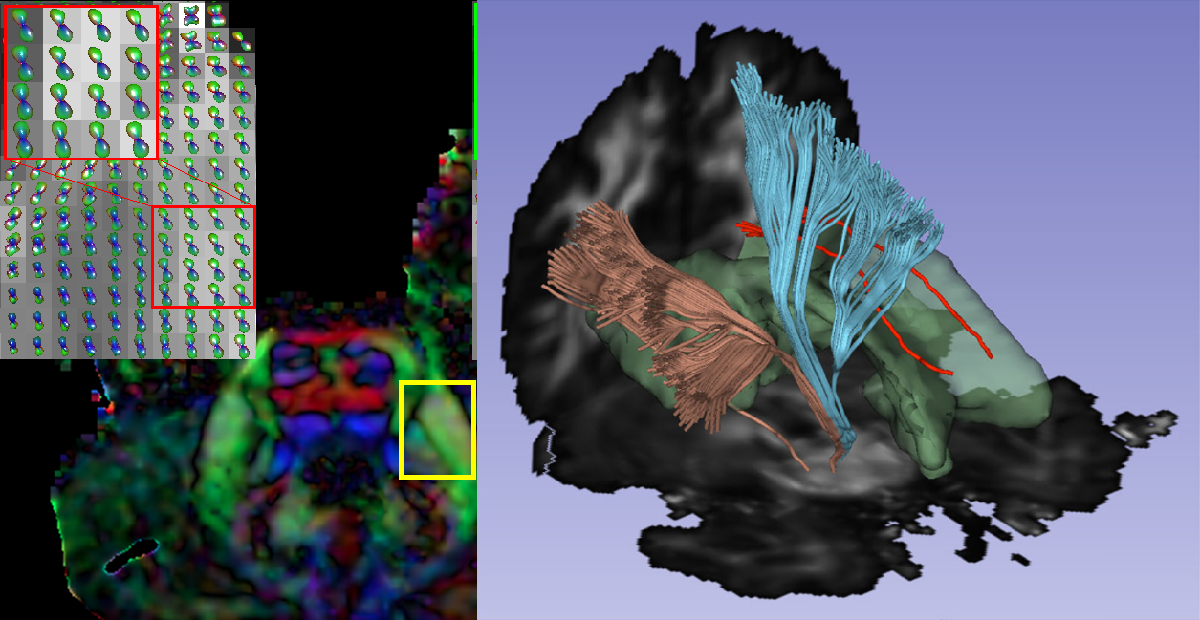
</p>


So, can <samp>dmrimatlab</samp> make this kind of plots? The answer is yes: <samp>dmrimatlab</samp> is able to compute and represent glyphs, and it also integrates several types of simple and advanced tractography algorithms. However, we will come back over this in the last chapter.


[Go back to index page](./tour_00index.ipynb)


[Previous](./tour_02data.ipynb)


[Next](./tour_04fwvf.ipynb)
